# AI Clinique #14 : Discover patterns in your data with Clustering
## Time Series Clustering

- __Date__: 26-11-2021
- __Presentator__: Nicolas Clavel
- __Datasets__: For this hands-on, we will be using the following open source datasets
    - CachedDataset Trace from tslearn.datasets
- __Packages__: requirements.txt
- __Documentation__:
    - Library tslearn clustering documentation: https://tslearn.readthedocs.io/en/stable/user_guide/clustering.html
    - Article : https://towardsdatascience.com/time-series-clustering-deriving-trends-and-archetypes-from-sequential-data-bb87783312b4


### Table of contents
- __1. Time Series dataset presentation__
- __2. KMeans on Time Series amplitude__
- __3. Dynamic Time Warping (DTW) on Time Series shape__
- __4. KMeans on Time Series derived features__

#### Imports

In [104]:
import numpy
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from tools import *

## 1. Time Series dataset presentation
ts* : time series

In [29]:
# for reproducibility
seed = 17
np.random.seed(seed)

In [11]:
# generate the time series dataset
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
print(f'X shape: {X_train.shape}')
print(f'y shape: {y_train.shape}')
print(f'Nb of time series: {X_train.shape[0]}')
print(f'Nb of points in time series: {X_train.shape[1]}')

X shape: (100, 275, 1)
y shape: (100,)
Nb of time series: 100
Nb of points in time series: 275


#### Vizual analysis of a sample

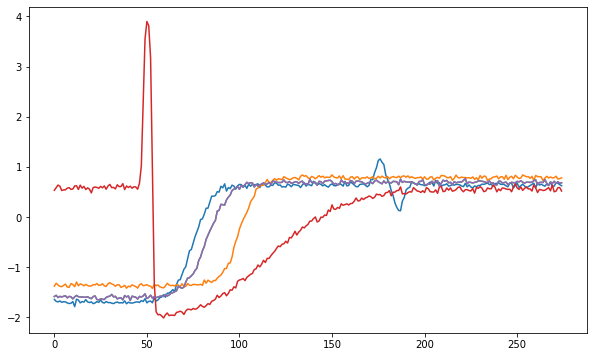

In [22]:
plt.rcParams["figure.figsize"] = (10,6)

random_ts = np.random.randint(0, X_train.shape[0]-1, 5)
for idx in random_ts:
    plt.plot(X_train[idx,:,:].ravel())

#### Vizual analysis inside a cluster

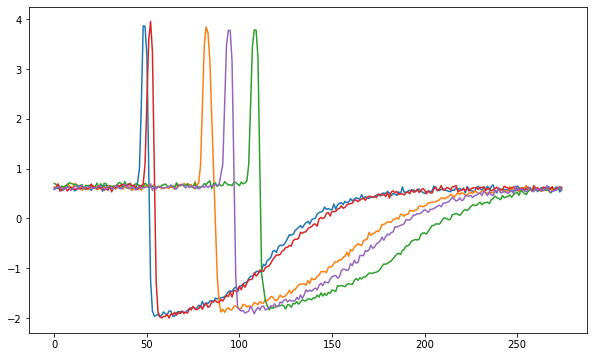

In [28]:
num_cluster = 1
X_train_in_cluster = X_train[y_train==num_cluster]

random_ts_in_cluster = np.random.randint(0, X_train_in_cluster.shape[0]-1, 5)
for idx in random_ts_in_cluster:
    plt.plot(X_train_in_cluster[idx,:,:].ravel())

It seems to have __4 shapes__ of time series.  
Let's try to perform a clustering analysis to see if we can identify these similar groups.

#### Preprocessing

In [30]:
len_ts = 60

In [31]:
# Keep only nb_ts time series
ts_scaler = TimeSeriesScalerMeanVariance()
X_train = ts_scaler.fit_transform(X_train)

# Resampling ts to make it shorter for computations purposes
ts_resampler = TimeSeriesResampler(sz=len_ts)
X_train = ts_resampler.fit_transform(X_train)
sz = X_train.shape[1]

print(f'X shapes : {X_train.shape}')
print(f'Number of time series : {X_train.shape[0]}')
print(f'Number of points in each time series : {X_train.shape[1]}')

X shapes : (100, 60, 1)
Number of time series : 100
Number of points in each time series : 60


## 2. KMeans on Time Series amplitudes

In [34]:
n_clusters = 4

In [39]:
# Euclidean k-means
km = TimeSeriesKMeans(n_clusters=n_clusters, random_state=seed)
y_pred = km.fit_predict(X_train)

#### Cluster 1

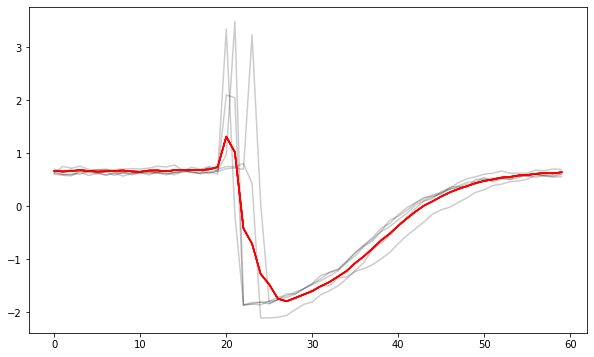

In [43]:
id_cluster = 0
X_train_pred_cluster_1 = X_train[y_pred == id_cluster]

# plot
plt.rcParams["figure.figsize"] = (10,6)
random_ts_pred_cluster_1 = np.random.randint(0, X_train_pred_cluster_1.shape[0]-1, 5)
for idx in random_ts_pred_cluster_1:
    plt.plot(X_train_pred_cluster_1[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[id_cluster].ravel(), "r-")

#### Cluster 2

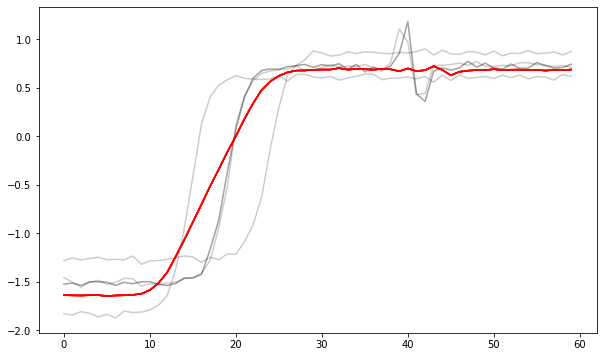

In [42]:
id_cluster = 1
X_train_pred_cluster_2 = X_train[y_pred == id_cluster]

# plot
random_ts_pred_cluster_2 = np.random.randint(0, X_train_pred_cluster_2.shape[0]-1, 5)
for idx in random_ts_pred_cluster_2:
    plt.plot(X_train_pred_cluster_2[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[id_cluster].ravel(), "r-")

#### Cluster 3

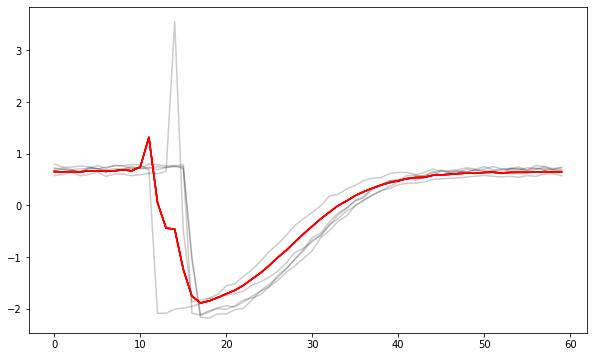

In [44]:
id_cluster = 2
X_train_pred_cluster_3 = X_train[y_pred == id_cluster]

# plot
random_ts_pred_cluster_3 = np.random.randint(0, X_train_pred_cluster_3.shape[0]-1, 5)
for idx in random_ts_pred_cluster_3:
    plt.plot(X_train_pred_cluster_3[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[id_cluster].ravel(), "r-")

#### Cluster 4

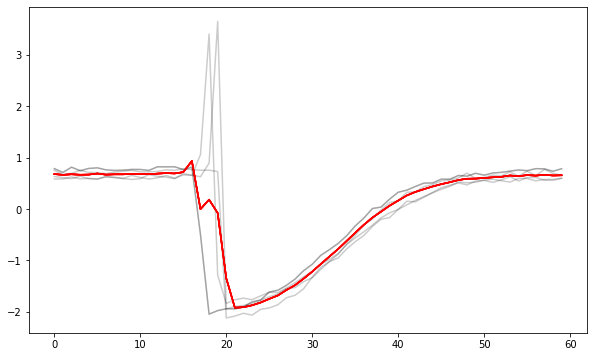

In [45]:
id_cluster = 3
X_train_pred_cluster_4 = X_train[y_pred == id_cluster]

# plot
random_ts_pred_cluster_4 = np.random.randint(0, X_train_pred_cluster_4.shape[0]-1, 5)
for idx in random_ts_pred_cluster_4:
    plt.plot(X_train_pred_cluster_4[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[id_cluster].ravel(), "r-")

In [52]:
# put in a dataframe
df_ts = pd.DataFrame({f'ts_{i}': X_train[i,:,:].ravel() for i in range(X_train.shape[0])})
df_ts_transpose = df_ts.T
df_ts_transpose['type_ts'] = y_train
df_ts_transpose['pred_type_ts'] = y_pred

In [54]:
pd.crosstab(df_ts_transpose['type_ts'], df_ts_transpose['pred_type_ts'])

pred_type_ts,0,1,2,3
type_ts,,,,
1,9,0,11,6
2,5,0,8,8
3,0,22,0,0
4,0,31,0,0


#### Conclusion:
__KMeans__ clustering used the __euclidian distance__ between the time series amplitudes : sum((ts_i[t] - ts_j[t])^2).  
If the time series have the same shape, but delayed, KMeans won't work, as we see.  
In the following section, we use another distance that even capture the delay between time series : __Dynamic Time Warping__ (DTW)

## 3. Dynamic Time Warping (DTW) on Time Series shape
In time series analysis, dynamic time warping (DTW) is one of the algorithms for measuring similarity between two temporal sequences that do not align exactly in time, speed, or length.  
https://towardsdatascience.com/time-series-clustering-deriving-trends-and-archetypes-from-sequential-data-bb87783312b4

In [68]:
n_clusters = 4
n_init = 3
metric = 'dtw'
max_iter_barycenter = 10

In [69]:
dtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=n_init,
                          metric=metric,
                          max_iter_barycenter=max_iter_barycenter)

y_pred_dtw = dtw_km.fit_predict(X_train)

#### Cluster 1

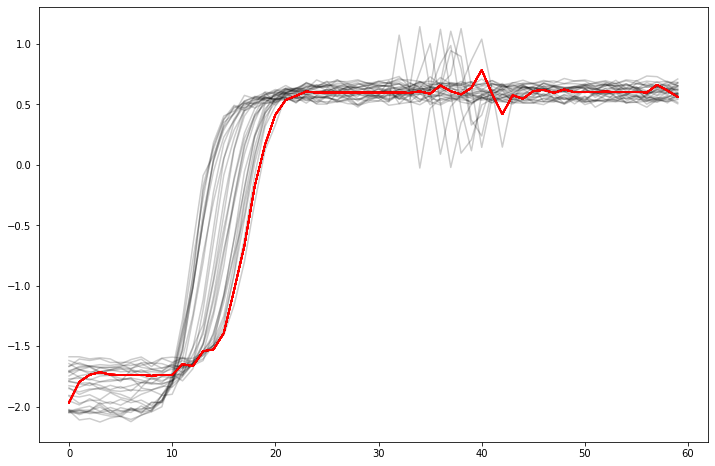

In [70]:
id_cluster = 0
X_train_pred_cluster_1_dtw = X_train[y_pred_dtw == id_cluster]

# plot
plt.rcParams["figure.figsize"] = (12,8)
for idx in range(X_train_pred_cluster_1_dtw.shape[0]):
    plt.plot(X_train_pred_cluster_1_dtw[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(dtw_km.cluster_centers_[id_cluster].ravel(), "r-")

#### Cluster 2

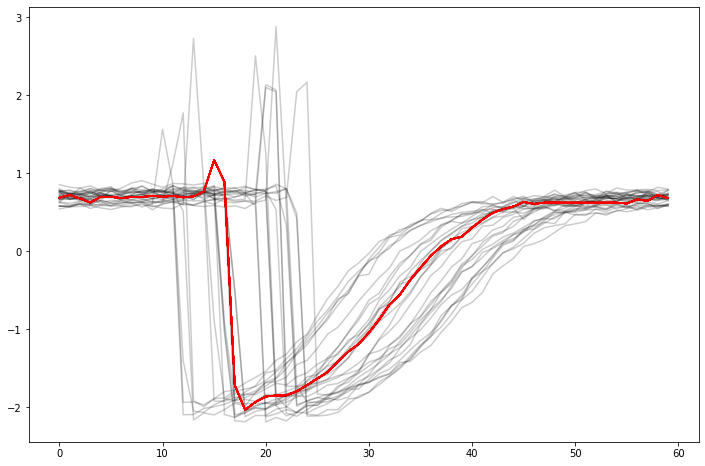

In [71]:
id_cluster = 1
X_train_pred_cluster_2_dtw = X_train[y_pred_dtw == id_cluster]

# plot
for idx in range(X_train_pred_cluster_2_dtw.shape[0]):
    plt.plot(X_train_pred_cluster_2_dtw[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(dtw_km.cluster_centers_[id_cluster].ravel(), "r-")

#### Cluster 3

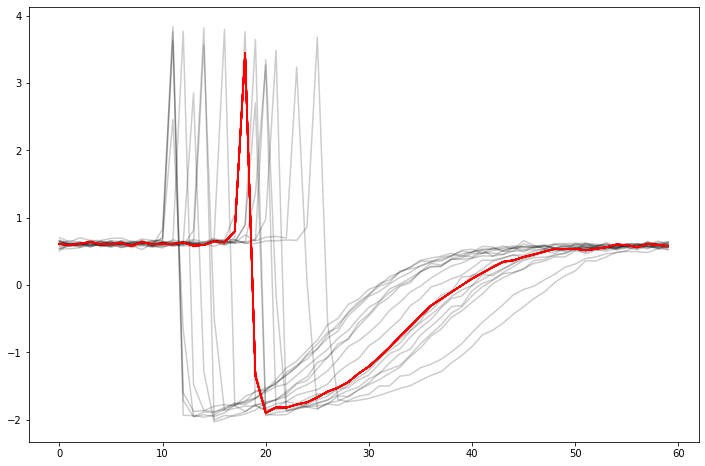

In [72]:
id_cluster = 2
X_train_pred_cluster_3_dtw = X_train[y_pred_dtw == id_cluster]

# plot
for idx in range(X_train_pred_cluster_3_dtw.shape[0]):
    plt.plot(X_train_pred_cluster_3_dtw[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(dtw_km.cluster_centers_[id_cluster].ravel(), "r-")

#### Cluster 4

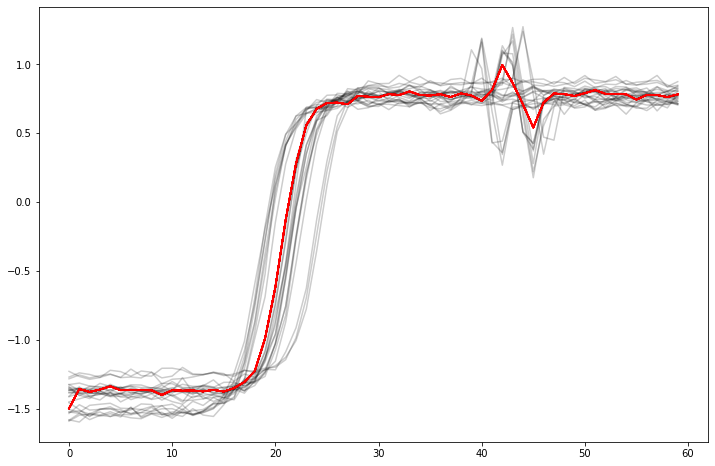

In [73]:
id_cluster = 3
X_train_pred_cluster_4_dtw = X_train[y_pred_dtw == id_cluster]

# plot
for idx in range(X_train_pred_cluster_4_dtw.shape[0]):
    plt.plot(X_train_pred_cluster_4_dtw[idx, :, :].ravel(), "k-", alpha=.2)
    plt.plot(dtw_km.cluster_centers_[id_cluster].ravel(), "r-")

In [74]:
df_ts_transpose['dtw_pred_type_ts'] = y_pred_dtw
pd.crosstab(df_ts_transpose['type_ts'], df_ts_transpose['dtw_pred_type_ts'])

dtw_pred_type_ts,0,1,2,3
type_ts,,,,
1,0,8,18,0
2,0,21,0,0
3,9,0,0,13
4,19,0,0,12


#### Conclusion:
DTW seems to be very slightly better than the Kmeans on the amplitudes of the Time Series.  
But it still lacks ability to differentiate between time series closed in shape.  
Let's try another method: Kmeans on derived time series features

## 4. KMeans on Time Series on derived features

#### Time Series derived features

In [144]:
df_cols = ['max', 'min', 'mean', 'max_abs', 'max-min', 'idx_max', 'idx_min', 'idx_max-idx_min', 'energy']
df_derived_features = pd.DataFrame(columns=df_cols)

# features
for idx, ts in enumerate(df_ts.columns):
    df_derived_features.loc[idx, 'max'] = df_ts[ts].max()
    df_derived_features.loc[idx, 'min'] = df_ts[ts].min()
    df_derived_features.loc[idx, 'mean'] = df_ts[ts].mean()
    df_derived_features.loc[idx, 'max_abs'] = df_ts[ts].abs().max()
    df_derived_features.loc[idx, 'max-min'] = df_ts[ts].max() - df_ts[ts].min()
    df_derived_features.loc[idx, 'idx_max'] = df_ts[ts].idxmax()
    df_derived_features.loc[idx, 'idx_min'] = df_ts[ts].idxmin()
    df_derived_features.loc[idx, 'idx_max-idx_min'] = df_ts[ts].idxmax() - df_ts[ts].idxmin()
    df_derived_features.loc[idx, 'energy'] = (df_ts[ts]**2).sum()/len(df_ts[ts])

In [145]:
df_derived_features

,max,min,mean,max_abs,max-min,idx_max,idx_min,idx_max-idx_min,energy
0,1.776125,-1.989286,0.003649,1.989286,3.76541,12,14,-2,0.873563
1,0.806783,-2.098047,0.019715,2.098047,2.90483,22,25,-3,0.984689
2,0.611228,-2.084833,-0.006732,2.084833,2.696061,53,5,48,1.019368
3,0.945088,-1.794408,-0.003442,1.794408,2.739497,37,5,32,1.013267
4,3.818697,-2.00564,0.016888,3.818697,5.824337,14,15,-1,1.034058
...,...,...,...,...,...,...,...,...,...
95,3.344039,-1.863939,0.00294,3.344039,5.207978,20,22,-2,0.951233
96,0.782713,-2.111352,0.01284,2.111352,2.894066,17,23,-6,0.989582
97,0.919565,-1.269995,-0.001754,1.269995,2.18956,32,5,27,1.002883
98,2.137744,-1.728263,0.014191,2.137744,3.866007,20,23,-3,0.913194


#### Kmeans

In [146]:
kmeans_derived_features = KMeans(n_clusters=4, n_init=50, max_iter=10000, random_state=3)

kmeans_derived_features.fit(df_derived_features)

# Get cluster labels
df_ts_transpose['kmeans_derived_features_cluster'] = kmeans_derived_features.labels_

In [147]:
pd.crosstab(df_ts_transpose['type_ts'], df_ts_transpose['kmeans_derived_features_cluster'])

kmeans_derived_features_cluster,0,1,2,3
type_ts,,,,
1,14,0,0,12
2,7,0,0,14
3,0,22,0,0
4,1,18,12,0
